In [43]:
import numpy as np
import matplotlib.pyplot as plt
from functions import polyeig, Spectral

plt.rcParams["figure.facecolor"] = "white"

In [2]:
N = 201
domain = "symmetric"
method = "FD"
spectral = Spectral(N,domain,method)

x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)
O = np.zeros_like(I)

#f = lambda x: 10*np.exp(-(10*x)**2)
f = lambda x: 10/(1+(10*x)**2)

## Finite-difference

$$ \left(-\omega^2 + 2f(z)\omega - f(z)^2-\frac{d^2}{dz^2}\right)\xi(z) = 0 $$

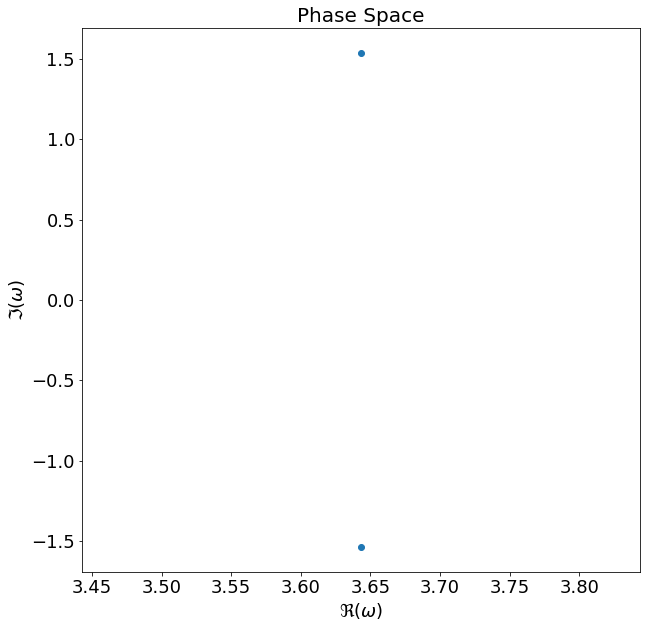

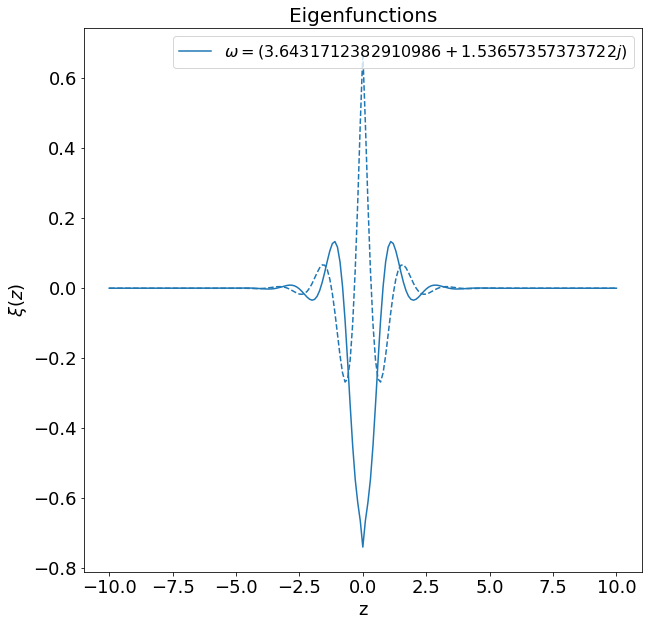

In [3]:
# finite-difference + polynomial eigenvalue problem
L = 10
A2 = -I
A1 = 2*f(L*x)*I
A0 = -(f(L*x)**2*I + D2/L**2)

V,omega = polyeig(A0,A1,A2)

selection = ~np.isclose(np.imag(omega),0)
#selection = (np.real(omega) > 0) & (np.real(omega)<5)
V = V[:,selection]
omega = omega[selection]

# sort
ind = np.argsort(omega)
V = V[:,ind]
omega = omega[ind]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
i = 1
xi = V[:,i]
lines = plt.plot(L*x,np.real(xi),'-',label=f"$\omega={omega[i]}$")
plt.plot(L*x,np.imag(xi),'--',color=lines[0]._color)
plt.title("Eigenfunctions")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")
plt.legend()

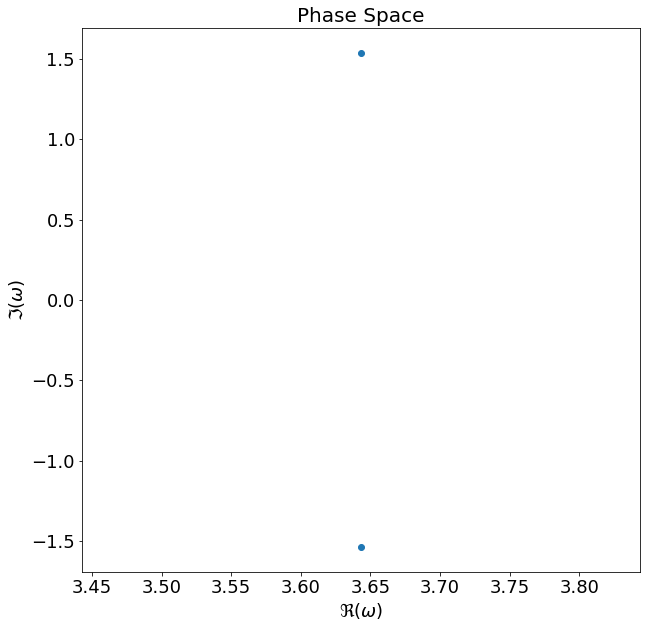

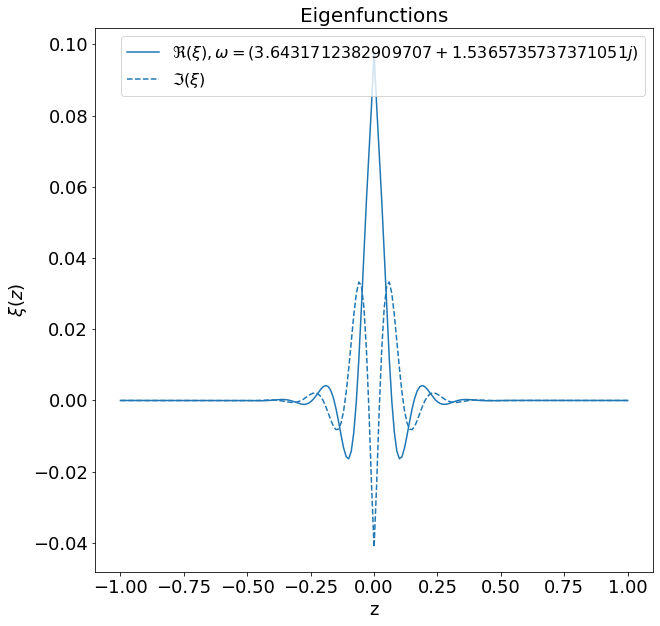

In [4]:
# finite-difference + linear eigenvalue solver
F = f(L*x)*I
H = -(f(L*x)**2*I + D2/L**2)

A = np.block([[O,I],[H,2*F]])

omega, V = np.linalg.eig(A)

selection = ~np.isclose(np.imag(omega),0)
V = V[:N,selection]
omega = omega[selection]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
xi = V[:,0]
lines = plt.plot(x,np.real(xi),'-',label=f"$\Re(\\xi),\omega={omega[0]}$")
plt.plot(x,np.imag(xi),'--',color=lines[0]._color,label="$\Im(\\xi)$")
plt.title("Eigenfunctions")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")
plt.legend()

## Finite-element
Let $\xi(z) = \frac{a_0}{2} + \sum_{n=1}^{N} a_n\cos(n\pi z)$, $\phi_n(z)=\cos(n\pi z)$. 
Then 

$$ H_{ij} = \langle\phi_i'|\phi_j'\rangle - \langle\phi_i|f^2|\phi_j\rangle = ij\pi^2\delta_{ij} - \int_{-1}^{1} \phi_i f^2 \phi_j $$
$$ f_{ij} = \langle\phi_i|f|\phi_j\rangle = \int_{-1}^{1} \phi_i f \phi_j  $$

In [5]:
from scipy.integrate import quad

M = 10

F = np.zeros((M,M))
H = np.zeros((M,M))
I = np.eye(M)
O = np.zeros_like(I)
L = 10

f = lambda x: 10*np.exp(-(L*x)**2)
phi = lambda x,n: np.cos(n*np.pi*x)
delta = lambda i,j: 1 if i==j else 0

# The basis function needs

for i in range(M):
    for j in range(M):
        F[i,j] = quad(lambda x: phi(x,i)*f(x)*phi(x,j), -L,L)[0]
        H[i,j] = quad(lambda x: i*j*(np.pi)**2*delta(i,j) - phi(x,i)*f(x)**2*phi(x,j), -L,L)[0]

Text(0, 0.5, '$\\xi(z)$')

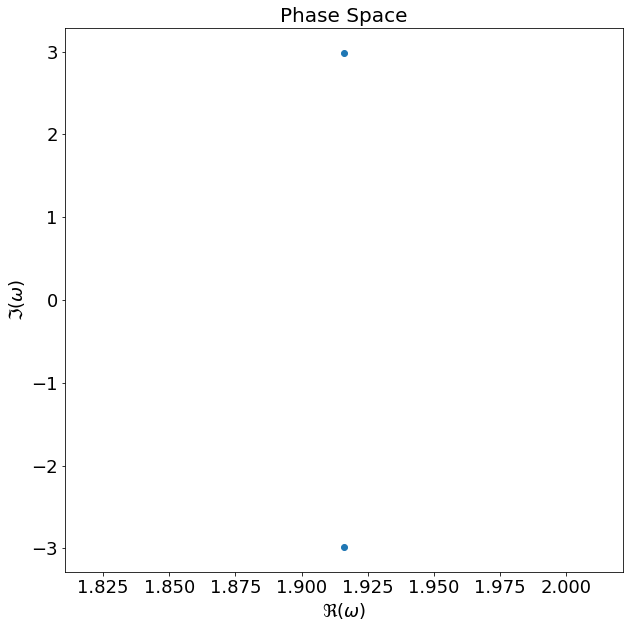

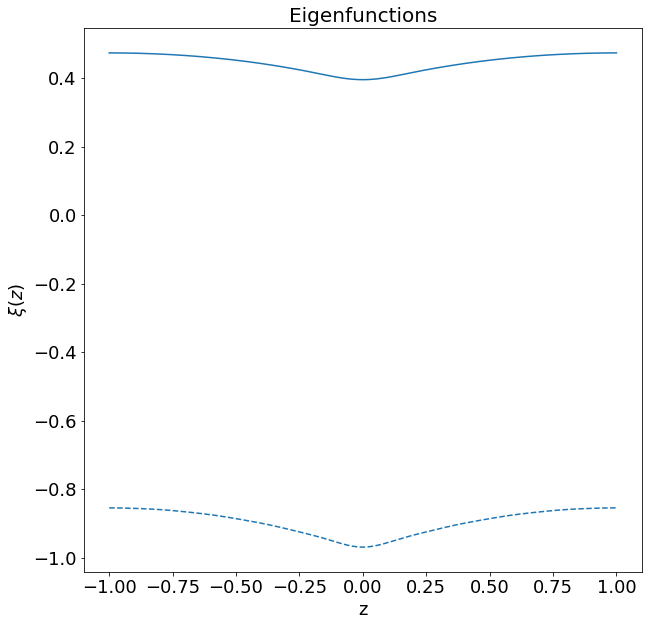

In [6]:
# finite-element + polynomial eigenvalue problem
A2 = -I
A1 = 2*F
A0 = H
V,omega = polyeig(A0,A1,A2)
selection = ~np.isclose(np.imag(omega),0)
V = V[:,selection]
omega = omega[selection]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
c = V[:,0]
phi_matrix = np.column_stack([phi(x,i) for i in range(M)])
xi = phi_matrix@c
lines = plt.plot(x,np.real(xi),'-',label="$\Re(\\xi)$")
plt.plot(x,np.imag(xi),'--',color=lines[0]._color,label="$\Im(\\xi)$")
plt.title("Eigenfunctions")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")

Text(0, 0.5, '$\\Im(\\omega)$')

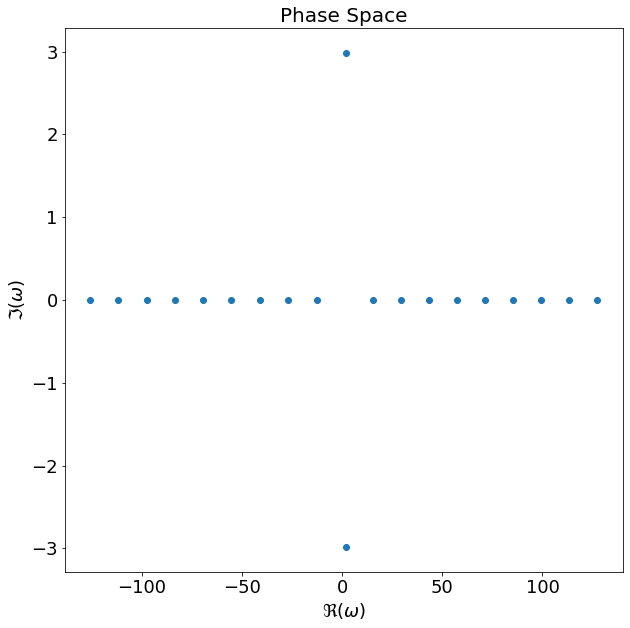

In [7]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[H,2*F]])
omega,V = np.linalg.eig(A)
plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

## Finite-element
Let $\xi(z) = \sum_{n=-N}^{N} a_n\phi_n(z)$ where $\phi_n(z)=sinc(z-n)$ and $sinc(z) = \begin{cases} \sin(z)/z, & z\neq 0 \\ 1, &z=0 \end{cases}$. 
Then 

$$ H_{ij} = \langle\phi_i'|\phi_j'\rangle - \langle\phi_i|f^2|\phi_j\rangle = \int_{-10}^{10} \phi_i' \phi_j' - \int_{-10}^{10} \phi_i f^2 \phi_j $$
$$ f_{ij} = \langle\phi_i|f|\phi_j\rangle = \int_{-10}^{10} \phi_i f \phi_j  $$

In [40]:
N = 100
domain = "symmetric"
method = "FD"
L = 100

spectral = Spectral(2*N+1,domain,method)
x = L*spectral.x

F = np.zeros((2*N+1,2*N+1))
H = np.zeros((2*N+1,2*N+1))
I = np.eye(2*N+1)
O = np.zeros_like(I)


def sinc(x:float):
    if x!=0:
        return np.sin(x)/x
    else:
        return 1

def sinc_p(x:float):
    """ derivative of sinc """
    if x!=0:
        return np.cos(x)/x - np.sin(x)/x**2
    else:
        return 0


f = lambda x: 10*np.exp(-x**2)
phi = lambda x,n: sinc(x-n)
phi_p = lambda x,n: sinc_p(x-n)

# The integrals of basis functions
for i in range(2*N+1):
    for j in range(2*N+1):
        i_shift, j_shift = i-N, j-N
        F[i,j] = quad(lambda x: phi(x,i_shift)*f(x)*phi(x,j_shift), -L,L)[0]
        H[i,j] = quad(lambda x: phi_p(x,i_shift)*phi_p(x,j_shift) - phi(x,i_shift)*f(x)**2*phi(x,j_shift), -L,L)[0]

Text(0, 0.5, '$\\xi(z)$')

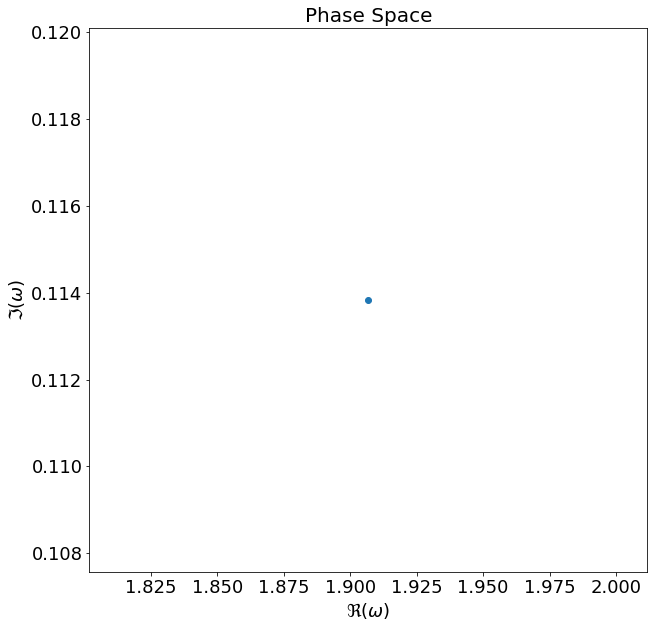

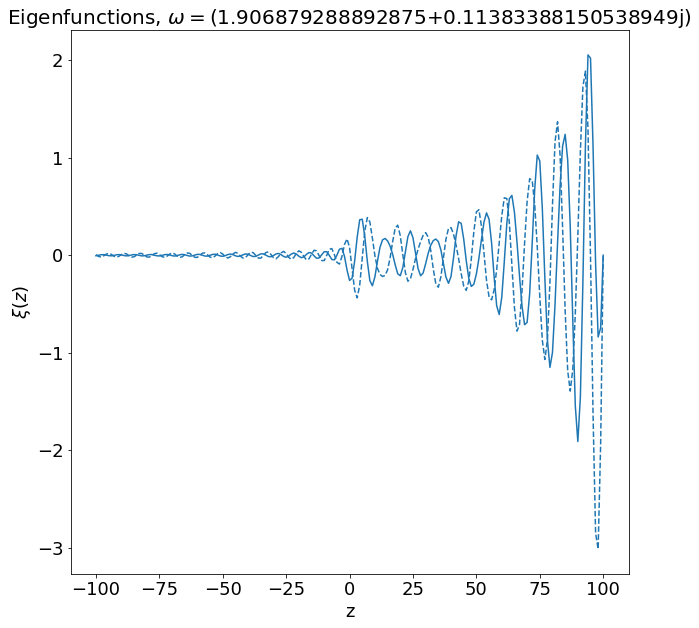

In [56]:
# finite-element + polynomial eigenvalue problem
A2 = -I
A1 = 2*F
A0 = H
V,omega = polyeig(A0,A1,A2)
selection = np.imag(omega) > 0.1
V = V[:,selection]
omega = omega[selection]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
c = V[:,0]
sinc = np.vectorize(sinc)
phi = lambda x,n: sinc(x-n)
phi_matrix = np.column_stack([phi(x,i) for i in range(2*N+1)])
xi = phi_matrix@c
lines = plt.plot(x,np.real(xi),'-',label="$\Re(\\xi)$")
plt.plot(x,np.imag(xi),'--',color=lines[0]._color,label="$\Im(\\xi)$")
plt.title(f"Eigenfunctions, $\omega=${omega[0]}")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")

Text(0, 0.5, '$\\Im(\\omega)$')

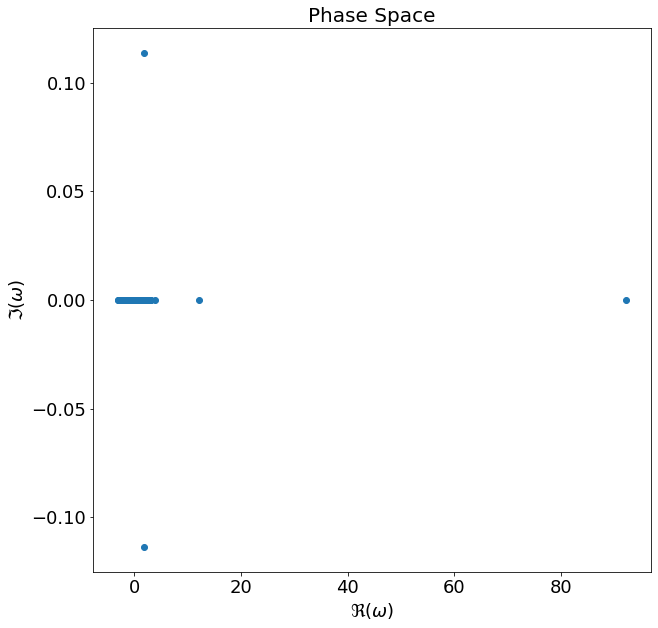

In [59]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[H,2*F]])
omega,V = np.linalg.eig(A)

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")